---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: true
    warning: false
    output: true
---

# Building our random forest model

Now that we have loaded and processed our data, we will proceed to build and test our random forest model.


In [1]:
# install libraries if needed
#%pip install statsmodels

# load necessary libraries
import os
import requests
import pysal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
import osmnx as ox
import statsmodels.api as sm
from folium import plugins
from sklearn.preprocessing import QuantileTransformer
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

First, let's load the data from the previous notebook.

In [2]:
# load processed data
geo_data = gpd.read_file("geo_data_crashes.geojson")

## Model design

Because the goal of this project is to predict future non-motorist crashes, we need to show how well our model can perform on existing data where we can verify predictions with observed data. Therefore, we will predict 2023 crashes using non-motorist crash data from the prior five years - 2018 through 2022 - as well as the spatially lagged counts of those crashes.

### Preparing the predictors

Along with our crash count and crash lag columns, we select the variables we created that are associated with commuting patterns, vehicle ownership, and road characteristics.

In [3]:
# select necessary columns
predictor_columns = [col for col in geo_data.columns if col.startswith("crash_") or col.endswith("_proportion") or col == "total_length" or col == "intersection_count" or col.startswith("pct_comm") or col.startswith("pct_veh")]

# ensure the 2023 crash variable is included
target_column = "crash_2023"

# filter the data to include only the selected columns and the target variable
data = geo_data[predictor_columns + [target_column]]

# drop rows with missing values
data = data.dropna()

# set columns for training and use data from 2018 through 2022
train_columns = [col for col in predictor_columns if col.startswith("crash_2018") or col.startswith("crash_2019") or col.startswith("crash_2020") or col.startswith("crash_2021") or col.startswith("crash_2022") or col.endswith("_proportion") or col == "total_length" or col == "intersection_count" or col.startswith("pct_")]

# remove the "pct_vehicle3plus" column for model simplicity and robustness
train_columns = [col for col in train_columns if col != "pct_vehicle3plus"]

#### Correlation matrix

The following matrix shows the correlations between the predictor variables. There is likely collinearity in the crash counts and lagged crashes, but we will keep them because we believe they are essential for the model.

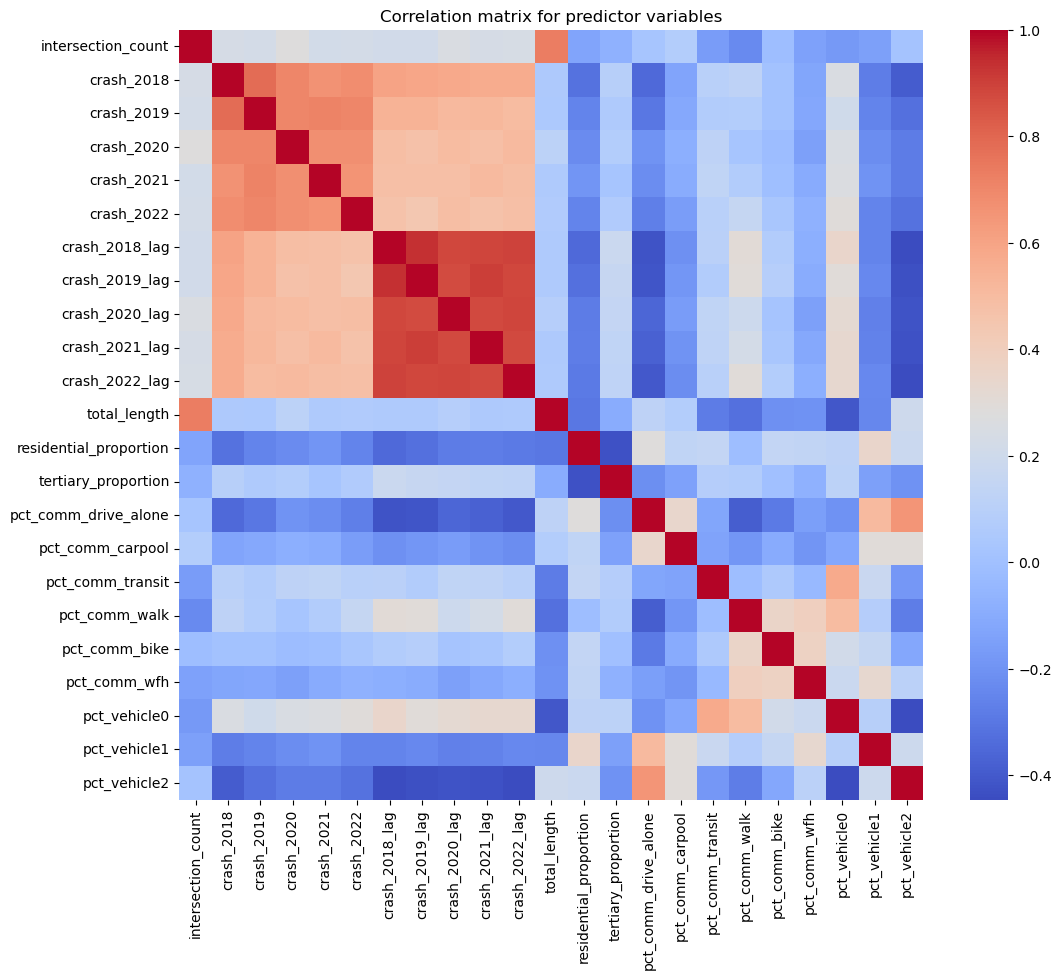

In [4]:
# filter data to include only selected columns
corr_data = geo_data[train_columns]

# compute correlation matrix
correlation_matrix = corr_data.corr()

# visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix for predictor variables")
plt.show()

### Model setup

Now, we will proceed to set up the random forest model. We will also add a robust scaler to the model instead of the standard scaler because it uses the median and interquartile range, which are less sensitive to outliers than the mean and standard deviation. We also use GridSearchCV to cross-validate the model and determine a set of optimized parameters.

In [5]:
# set up training and testing datasets
X_train = data[train_columns]
y_train = data[target_column]
X_test = data[train_columns]
y_test = data[target_column]

# deduplicate y columns
y_train = y_train.loc[:, ~y_train.columns.duplicated()]
y_test = y_test.loc[:, ~y_test.columns.duplicated()]

# reshape y_train and y_test to be 1-dimensional arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# set up random forest pipeline
forest = make_pipeline(
    RobustScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# generate hyperparameter grid
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

# create grid and use 3-fold CV
grid = GridSearchCV(forest, param_grid, cv=3, verbose=1)

# run the model
grid.fit(X_train, y_train)

# optional - display optimized hyperparameters
#grid.best_params_

# optional - show score
#grid.score(X_test, y_test)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13,
                                                              21, 33, 51],
                         'randomforestregressor__n_estimators': [5, 10, 15, 20,
                                                                 30, 50, 100,
                                                                 200]},
             verbose=1)

Now, we will fit and evaluate the random forest model using two metrics: mean absolute error and Poisson deviance. The mean absolute error gives us the error in terms of crashes, while the Poisson deviance is a goodness-of-fit metric for that we calculate mainly to provide a standard of comparison to other models. A lower score indicates a better fit to the Poisson distribution, which is appropriate for count-based events like injuries and crashes.

In [6]:
# use the optimal random forest model
best_random = grid.best_estimator_

# make the predictions
predictions = best_random.predict(X_test)

# calculate absolute error
errors = predictions - y_test
abs_errors = abs(predictions - y_test)
avg_error = np.mean(abs_errors)

# calculate poisson deviance
poisson_deviance = mean_poisson_deviance(y_test, predictions)

print("Model performance")
print(f"Mean absolute error: {avg_error:0.4f} crashes")
print("We do not report MAPE because of zero values in the observed data")
print(f"Poisson deviance: {poisson_deviance}")

Model performance
Mean absolute error: 0.8172 crashes
We do not report MAPE because of zero values in the observed data
Poisson deviance: 0.5216537518327811


The model predictions had a mean absolute error of about 0.8 crashes, which is nowhere close to perfect, but may still be a decent model in comparison to other options. The Poisson deviance is approximately 0.52. 

Now, let's map the predicted values.

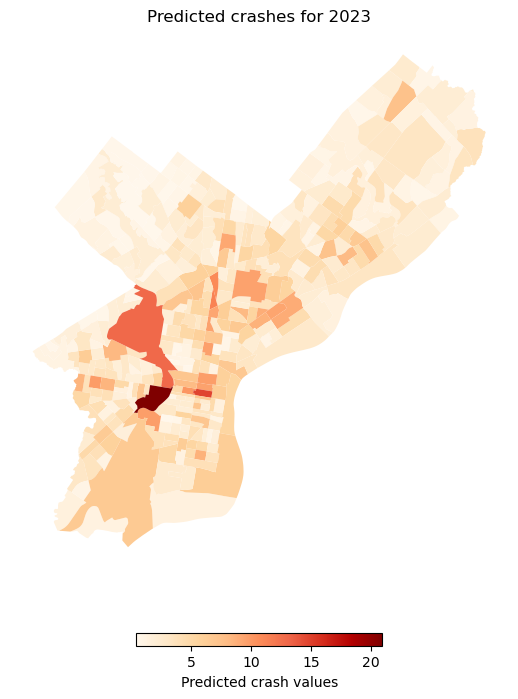

In [7]:
# merge predictions back into geo_data
geo_data['predicted_crashes'] = predictions

# define a color map and normalization
vmin = geo_data['predicted_crashes'].min()
vmax = geo_data['predicted_crashes'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'OrRd'  # Using 'OrRd' as the color map

# create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# plot the map for predicted crashes
geo_data.plot(column='predicted_crashes', cmap=cmap, norm=norm, ax=ax, legend=False)
ax.set_title('Predicted crashes for 2023')

# add a color bar
scalarmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scalarmap.set_array([])
cbar = fig.colorbar(scalarmap, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Predicted crash values')

# remove the axes
ax.axis('off')

plt.show()

The model predicts high crash counts in University City, Kensington, and the Market East/Chinatown section of Center City, as well as along North Broad Street and the western end of Market Street. The large tract encompassing Fairmount Park and parts of West Philadelphia also has a higher number of crashes.

Let's now evaluate the model performance by mapping the errors.

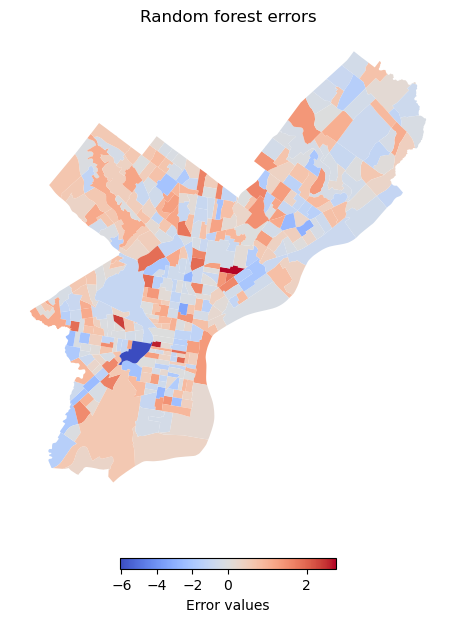

In [8]:
# add errors to geo_data
geo_data['rf_errors'] = errors

# define color map and normalization for random forest errors
vmin = geo_data['rf_errors'].min()
vmax = geo_data['rf_errors'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = 'coolwarm'  # Using 'coolwarm' as the diverging color map

# create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# map for random forest errors
geo_data.plot(column='rf_errors', cmap=cmap, norm=norm, ax=ax, legend=False)
ax.set_title('Random forest errors')

# color bar
scalarmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scalarmap.set_array([])
cbar = fig.colorbar(scalarmap, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Error values')

# remove the axes
ax.axis('off')

# show map
plt.show()

The map shows that error values are distributed across the city and not clustered in any specific area, other than University City, which has the greatest error magnitude at around -6 crashes. The map also shows that the model did not severely overpredict or underpredict in most tracts.

## Comparison with Poisson regression

For the sake of comparison with a more traditional model that is used for count data, we will run a Poisson regression to predict 2023 crash counts using the same predictor variables as the random forest model.

In [9]:
# add a constant to the predictors (intercept term)
X_train_nb = sm.add_constant(X_train)
X_test_nb = sm.add_constant(X_test)

# fit the poisson regression model
nb_model = sm.GLM(y_train, X_train_nb, family=sm.families.Poisson()).fit()

# make predictions
nb_predictions = nb_model.predict(X_test_nb)

# calculate the absolute errors
nb_errors = abs(nb_predictions - y_test)

# calculate average error
nb_avg_error = np.mean(nb_errors)

# calculate poisson deviance
nb_poisson_deviance = mean_poisson_deviance(y_test, nb_predictions)

print("Poisson model performance")
print(f"Average absolute error: {nb_avg_error:0.4f} crashes")
print("We do not report MAPE because of zero values in the observed data")
print(f"Poisson deviance: {nb_poisson_deviance}")

Poisson model performance
Average absolute error: 1.5590 crashes
We do not report MAPE because of zero values in the observed data
Poisson deviance: 1.3527141666894478


The average absolute error was much greater than that of the random forest model, as well as the Poisson deviance. This suggests that the Poisson model underperforms in comparison to the random forest model.

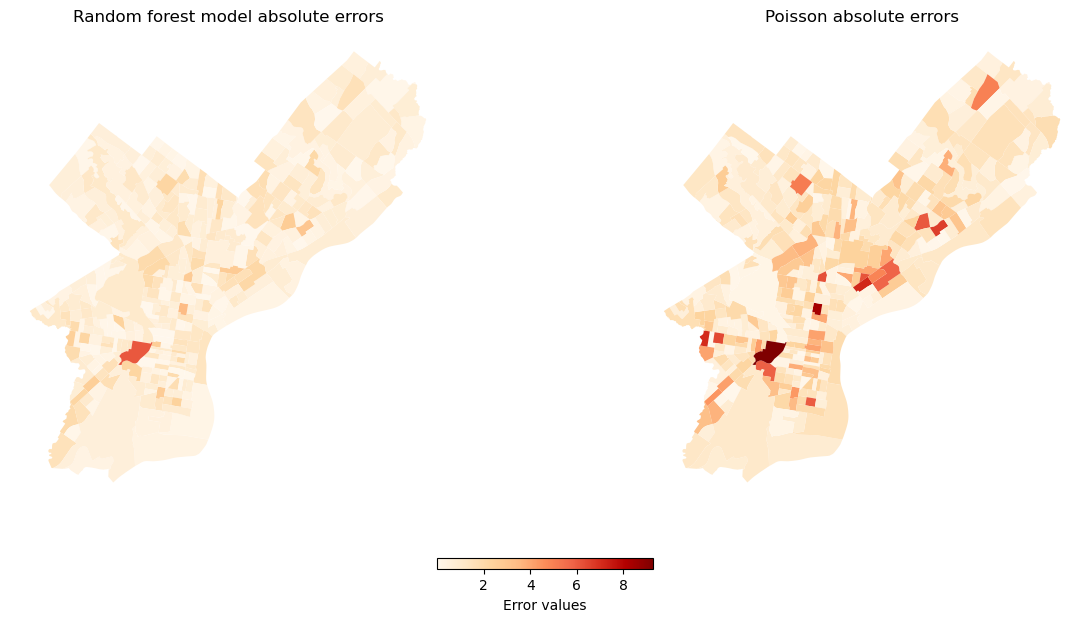

In [10]:
# add absolute errors to geo_data
geo_data['nb_errors'] = nb_errors
geo_data['abs_errors'] = abs_errors

# define common color map and normalization
vmin = min(geo_data['abs_errors'].min(), geo_data['nb_errors'].min())
vmax = max(geo_data['abs_errors'].max(), geo_data['nb_errors'].max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'OrRd'  # Using 'OrRd' as the common color map

# create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# map for random forest errors
geo_data.plot(column='abs_errors', cmap=cmap, norm=norm, ax=ax1, legend=False)
ax1.set_title('Random forest model absolute errors')

# map for poisson errors
geo_data.plot(column='nb_errors', cmap=cmap, norm=norm, ax=ax2, legend=False)
ax2.set_title('Poisson absolute errors')

# shared color bar
scalarmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scalarmap.set_array([])
cbar = fig.colorbar(scalarmap, ax=[ax1, ax2], orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Error values')

# remove the axes
ax1.axis('off')
ax2.axis('off')

# show maps
plt.show()

We can see that the Poisson model had huge errors when predicting crashes in University City, as well as some tracts in Kensington and Center City. The random forest model also overpredicted in University City, but not nearly to the same extent.

From this comparison, we suggest that predictions of non-motorist crash risk, as well as motor vehicle crash risk in general, can benefit from more advanced machine learning techniques like optimized random forest regression. 

Now, let's produce predictions for 2024 before wrapping up our analysis.

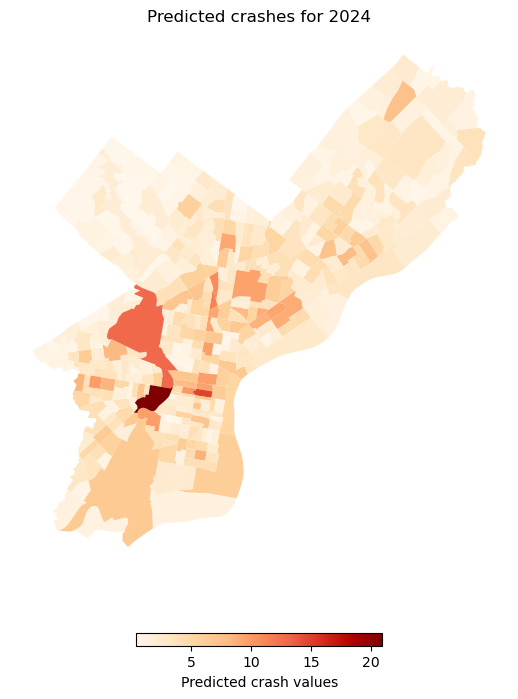

In [11]:
# set columns to predict on and use data from 2019 through 2023
train_columns_24 = [col for col in predictor_columns if col.startswith("crash_2019") or col.startswith("crash_2020") or col.startswith("crash_2021") or col.startswith("crash_2022") or col.startswith("crash_2023") or col.endswith("_proportion") or col == "total_length" or col == "intersection_count" or col.startswith("pct_")]

# remove the "pct_vehicle3plus" column for model simplicity and robustness
train_columns_24 = [col for col in train_columns if col != "pct_vehicle3plus"]

X_test_24 = data[train_columns_24]
predictions_24 = best_random.predict(X_test_24)

# merge predictions back into geo_data
geo_data['predicted_24'] = predictions_24

# define a color map and normalization
vmin = geo_data['predicted_24'].min()
vmax = geo_data['predicted_24'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'OrRd'  # Using 'OrRd' as the color map

# create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# plot the map for predicted crashes
geo_data.plot(column='predicted_24', cmap=cmap, norm=norm, ax=ax, legend=False)
ax.set_title('Predicted crashes for 2024')

# add a color bar
scalarmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scalarmap.set_array([])
cbar = fig.colorbar(scalarmap, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Predicted crash values')

# remove the axes
ax.axis('off')

plt.show()

The predictions are quite similar between 2023 and 2024, which is expected because of the four shared years of data between the two predictor datasets.

# Conclusion and recommendations

Based on our results, we suggest that random forest modeling techniques are useful for predicting non-motorist crash risk in Philadelphia. Our prediction of non-motorist crash risk shows that University City, Market East, Fairmount Park, North Broad Street, western Market Street, and Kensington should be focus areas for traffic calming and urban design improvements to prevent further vehicular collisions with non-motorists.

We also recommend further refinement of the model, using more relevant data and adjusting the number of years of prior crash data to use in the prediction process. The geographic unit may be changed to block groups, fishnet grid cells, or road segments to improve the granularity and precision of the features and model predictions. Further variables to describe the characteristics of the road network, such as speed limits and highway off-ramp locations, may be useful in improving the accuracy of the model.